
Time Series Analysis and Forecasting with CNNs

Convolutional Neural Network models, or CNNs for short, can be applied to time series forecasting. I will be presenting different type of scenarios that we usually come across during solving problems related with time series and the variety of CNN architectures that we can use to tackle them.

Variety of time series related problems:

1. CNN Models for Univariate time series

2. CNN Models for Multivariate time series

3. CNN Models for Multistep time series

4. CNN Models for Multivariate and Multisteps time series

Imports

In [5]:
import torch 
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import mean_squared_error


Data Description

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

global active power: The total active power consumed by the household (kilowatts).

global reactive power: The total reactive power consumed by the household (kilowatts). ˆ voltage: Average voltage (volts).

global intensity: Average current intensity (amps).

sub metering 1: Active energy for kitchen (watt-hours of active energy).

sub metering 2: Active energy for laundry (watt-hours of active energy).

sub metering 3: Active energy for climate control systems (watt-hours of active energy).


Problem Framing
Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption?

Solution Approach

Since we have to do some kind of prediction for whole week or for each day for next 7 days, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps.

A model that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.

This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals.

Train and Test Sets

We will use the first 3 years of data for training predictive models and the final year for evaluating models.

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday. This is a realistic and useful way for using the chosen framing of the model, where the power consumption for the week ahead can be predicted.

It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.

In [26]:
df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/3140453207.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/3140453207.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('Data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/i

In [27]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [28]:
df.shape

(2075259, 7)

In [29]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [30]:
#Missing value 
df.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [31]:
df['Sub_metering_2'].unique()

array(['1.000', '2.000', '0.000', '16.000', '37.000', '36.000', '22.000',
       '12.000', '27.000', '20.000', '9.000', '4.000', '3.000', '5.000',
       '13.000', '35.000', '28.000', '26.000', '24.000', '21.000',
       '17.000', '33.000', '25.000', '23.000', '18.000', '30.000',
       '31.000', '7.000', '38.000', '29.000', '50.000', '71.000',
       '59.000', '62.000', '70.000', '40.000', '34.000', '8.000',
       '15.000', '6.000', '32.000', '19.000', '14.000', '49.000',
       '72.000', '73.000', '61.000', '39.000', '42.000', '10.000',
       '56.000', '11.000', '?', '43.000', '67.000', '63.000', '53.000',
       '65.000', '52.000', '69.000', '48.000', '74.000', '41.000',
       '47.000', '58.000', '68.000', '64.000', '75.000', '46.000',
       '57.000', '60.000', '66.000', '44.000', '78.000', '77.000',
       '76.000', '51.000', '55.000', '45.000', '54.000', '79.000',
       '80.000'], dtype=object)

In [33]:
# we have "?" in the columns so we need to replace it 

df.replace('?',None,inplace=True)

In [34]:
df['Sub_metering_3'].unique()

array([17., 16., 18.,  9.,  0.,  5., 19., 10., 20.,  8.,  4.,  2.,  3.,
       11., 13.,  6., 15., nan, 12.,  1., 14.,  7., 23., 25., 26., 28.,
       27., 21., 22., 29., 24., 30., 31.])

In [35]:
df['Sub_metering_2'].unique()

array(['1.000', '2.000', '0.000', '16.000', '37.000', '36.000', '22.000',
       '12.000', '27.000', '20.000', '9.000', '4.000', '3.000', '5.000',
       '13.000', '35.000', '28.000', '26.000', '24.000', '21.000',
       '17.000', '33.000', '25.000', '23.000', '18.000', '30.000',
       '31.000', '7.000', '38.000', '29.000', '50.000', '71.000',
       '59.000', '62.000', '70.000', '40.000', '34.000', '8.000',
       '15.000', '6.000', '32.000', '19.000', '14.000', '49.000',
       '72.000', '73.000', '61.000', '39.000', '42.000', '10.000',
       '56.000', '11.000', None, '43.000', '67.000', '63.000', '53.000',
       '65.000', '52.000', '69.000', '48.000', '74.000', '41.000',
       '47.000', '58.000', '68.000', '64.000', '75.000', '46.000',
       '57.000', '60.000', '66.000', '44.000', '78.000', '77.000',
       '76.000', '51.000', '55.000', '45.000', '54.000', '79.000',
       '80.000'], dtype=object)

In [36]:
df["Sub_metering_3"]=df[['Sub_metering_3']].fillna(method='ffill')

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/2024096273.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sub_metering_3"]=df[['Sub_metering_3']].fillna(method='ffill')


In [38]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object


Most of the ML models expect data to be of float32 type

In [39]:
df=df.astype('float32')

In [40]:
df.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtype: object


Downsampling data to day level

In [41]:
#resamoling 

daily_df=df.resample("D")
dataset=daily_df.sum()

dataset.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0


In [62]:
dataset.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0
2006-12-21,1716.624023,144.166000,346616.31250,7238.600098,1765.0,2623.0,10421.0
2006-12-22,2341.337891,186.906006,347305.75000,9897.000000,3151.0,350.0,11131.0
2006-12-23,4773.386230,221.470001,345795.93750,20200.400391,2669.0,425.0,14726.0
2006-12-24,2550.011963,149.899994,348029.90625,11002.200195,1703.0,5082.0,6891.0


In [42]:
dataset.tail(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-24,1796.248047,132.460007,345644.59375,7559.399902,1096.0,2848.0,12224.0
2010-11-25,1431.163940,116.127998,347812.21875,6004.000000,1076.0,426.0,5072.0
2010-11-26,1488.104004,120.826004,303487.56250,6259.799805,1080.0,385.0,9989.0



Train and Test Split

The final year of the data is in 2010 and the first Sunday for 2010 was January 3rd. The data ends in mid November 2010 and the closest final Saturday in the data is November 20th. This gives 46 weeks of test data.

The function split dataset() below splits the daily data into train and test sets and organizes each into standard weeks. Specific row offsets are used to split the data using knowledge of the dataset.

The split datasets are then organized into weekly data using the NumPy split() function.

In [76]:
dataset.shape

(1442, 7)

In [43]:

from numpy import array, split


In [58]:

def split_dataset(data):
    #split into standard weeks
    train_sample, test_sample = data[1:-328], data[-328:-6]
    print(train_sample[0])
    print("----------")
    print(test_sample[0])
    train = torch.tensor(split(train_sample, len(train_sample)/7))
    test = torch.tensor(split(test_sample, len(test_sample)/7))

    return train, test

In [59]:
train, test=split_dataset(dataset.values)

[3.390460e+03 2.260060e+02 3.457253e+05 1.439860e+04 2.033000e+03
 4.187000e+03 1.334100e+04]
----------
[2.0834541e+03 1.9161000e+02 3.5099212e+05 8.7035996e+03 3.8420000e+03
 4.9200000e+03 1.0074000e+04]


/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/664690823.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  train = torch.tensor(split(train_sample, len(train_sample)/7))


In [68]:
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

torch.Size([159, 7, 7])
tensor(3390.4600) tensor(1308.8361)
torch.Size([46, 7, 7])
tensor(2083.4541) tensor(2197.0061)


In [75]:
train.shape

torch.Size([159, 7, 7])

In [92]:
train[0]

tensor([[3.3905e+03, 2.2601e+02, 3.4573e+05, 1.4399e+04, 2.0330e+03, 4.1870e+03,
         1.3341e+04],
        [2.2038e+03, 1.6179e+02, 3.4737e+05, 9.2472e+03, 1.0630e+03, 2.6210e+03,
         1.4018e+04],
        [1.6662e+03, 1.5094e+02, 3.4848e+05, 7.0940e+03, 8.3900e+02, 7.6020e+03,
         6.1970e+03],
        [2.2257e+03, 1.6100e+02, 3.4892e+05, 9.3130e+03, 0.0000e+00, 2.6480e+03,
         1.4063e+04],
        [1.7166e+03, 1.4417e+02, 3.4662e+05, 7.2386e+03, 1.7650e+03, 2.6230e+03,
         1.0421e+04],
        [2.3413e+03, 1.8691e+02, 3.4731e+05, 9.8970e+03, 3.1510e+03, 3.5000e+02,
         1.1131e+04],
        [4.7734e+03, 2.2147e+02, 3.4580e+05, 2.0200e+04, 2.6690e+03, 4.2500e+02,
         1.4726e+04]])

In [107]:
def to_supervised(train,n_input,n_out=7):
    data=train.reshape(train.shape[0]*train.shape[1],train.shape[2])
    X,y=[],[]
    in_start=0

    for _ in range(len(data)):
        in_end=in_start+n_input
        out_end=in_end +n_out

        if out_end<len(data):
            x_input=data[in_start:in_end,0]
            x_input=x_input.view((len(x_input),1))
            X.append(x_input)
            y.append(data[in_end:out_end,0])
        in_start+=1

    return torch.stack(X),torch.stack(y)


In [108]:
X,y=to_supervised(train,7,7)

In [109]:
X.shape

torch.Size([1099, 7, 1])


When we run the above function on the entire training dataset, we transform 159 samples into 1,099; specifically, the transformed dataset has the shapes X=[1099, 7, 1] and y=[1099, 7].

In [110]:
train[0] 

tensor([[3.3905e+03, 2.2601e+02, 3.4573e+05, 1.4399e+04, 2.0330e+03, 4.1870e+03,
         1.3341e+04],
        [2.2038e+03, 1.6179e+02, 3.4737e+05, 9.2472e+03, 1.0630e+03, 2.6210e+03,
         1.4018e+04],
        [1.6662e+03, 1.5094e+02, 3.4848e+05, 7.0940e+03, 8.3900e+02, 7.6020e+03,
         6.1970e+03],
        [2.2257e+03, 1.6100e+02, 3.4892e+05, 9.3130e+03, 0.0000e+00, 2.6480e+03,
         1.4063e+04],
        [1.7166e+03, 1.4417e+02, 3.4662e+05, 7.2386e+03, 1.7650e+03, 2.6230e+03,
         1.0421e+04],
        [2.3413e+03, 1.8691e+02, 3.4731e+05, 9.8970e+03, 3.1510e+03, 3.5000e+02,
         1.1131e+04],
        [4.7734e+03, 2.2147e+02, 3.4580e+05, 2.0200e+04, 2.6690e+03, 4.2500e+02,
         1.4726e+04]])

Next, we can define and fit the CNN model on the training data. This multi-step time series forecasting problem is an autoregression

Model Architecture

convolution layer with 16 filters and kernel size = 3

Relu activation function

A pooling layer

Flattening

Linear layer with 10 nodes

Relu activation function

Linear layer with n_out nodes

MSE as loss function

Optimizer - Adam

In [125]:
#define Model

class UnivariateCNNModel(nn.Module):
    def __init__(self,n_timestamp,n_features):
        super().__init__()
        self.conv_net=nn.Sequential(
            nn.Conv1d(in_channels=n_features,out_channels=16,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.flt_layer=nn.Flatten()
        self.ln_layer=nn.Sequential(
            nn.Linear(in_features=32,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=n_timestamp)
        )
    def forward(self, X):
        #X -> (B, T, C)
        B, T, C = X.shape
        X = X.view(B, C, T)
        X = self.conv_net(X)
        # print(X.shape)
        X = self.flt_layer(X)
        X = self.ln_layer(X)

        return X
    

    

In [126]:
n_timestamp=7
n_features=1

model=UnivariateCNNModel(n_timestamp,n_features)

In [127]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

In [128]:
n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]

print(f"n_timesteps : {n_timesteps}, n_features : {n_features}, n_outputs : {n_outputs}")

n_timesteps : 7, n_features : 1, n_outputs : 7


Training Loop

In [129]:
epochs=5

losses=[]

for _ in range(epochs):
    optimizer.zero_grad()
    y_pred=model(X)
    loss=criterion(y_pred,y)
    print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()



2476169.75
2456234.75
2436106.25
2415704.0
2394994.0


Text(0, 0.5, 'Training Loss')

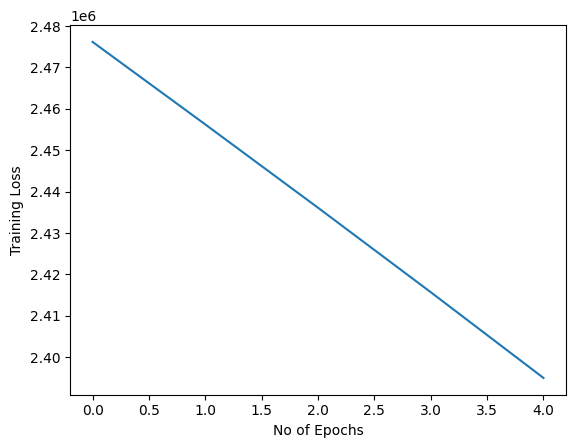

In [130]:
#plot the training losses

plt.plot(losses)
plt.xlabel("No of Epochs")
plt.ylabel("Training Loss")


Models will be evaluated using a scheme called walk-forward validation. This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week.

This is both realistic for how the model may be used in practice and beneficial to the models, allowing them to make use of the best available data.

For example:

Input -> predict

[Week1] -> Week2

[Week1 + Week2]  -> Week3

[Week1 + Week2 + Week3]  ->  Week4

In [131]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [132]:
def evaluate_forecasts(actual, predicted):
  
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores


In [133]:

history = [x for x in train]

data = array(history)
print(data.shape)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
input_x = data[-7:, 0]
print(input_x)

(159, 7, 7)
[2195.452 2094.098 2047.968 2451.11  2211.892 1224.252 1308.836]


In [134]:

dataset.shape

(1442, 7)

In [135]:
X[-1][None][0]

tensor([[2204.3340],
        [1144.1660],
        [2034.9659],
        [1888.0220],
        [1455.2000],
        [2905.8940],
        [2127.6479]])

In [136]:
model.forward(X[-1][None])[0]

tensor([ 53.0107, 136.5690, 123.3456, 574.1218, 309.4821,  24.6641,  18.9055],
       grad_fn=<SelectBackward0>)

In [137]:

train[-1][:, 0][None]

tensor([[2195.4519, 2094.0979, 2047.9680, 2451.1101, 2211.8921, 1224.2520,
         1308.8361]])

In [138]:
test.shape

torch.Size([46, 7, 7])

In [139]:

#evaluation 

#get the last train 
n_test = len(test)
n_input = 7

#extract the last 7 days training data from train
history = train[-1][:, 0]
#rehsape hist into (B, T, C)
B = 1
T = 7
C = 1

predictions = []

for i in range(n_test):
    n_in = 0
    # reshape the data from (B, T, C) -> (B, C, T)
    history = torch.tensor(history).view(B, T, C)
    # # reshape into [1, n_input, 1]
    with torch.no_grad():
        yhat = model.forward(history)
        # store the predictions
        predictions.append(yhat[0].tolist())
    history = test[i][n_in:n_in+n_input, 0]
    n_in += n_input
    
predictions = array(predictions)
score, scores = evaluate_forecasts(array(test[:, :, 0].tolist()), predictions)

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_5735/4249578011.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  history = torch.tensor(history).view(B, T, C)


cnn: [1440.305] 1599.8, 1415.9, 1422.3, 1159.9, 1267.0, 1463.1, 1686.0


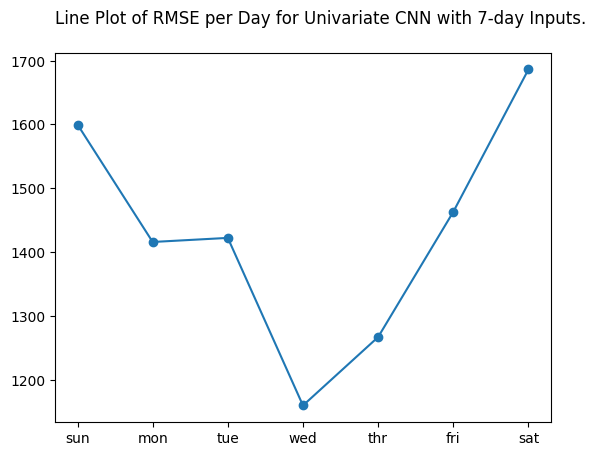

In [140]:

# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn') 
plt.title("Line Plot of RMSE per Day for Univariate CNN with 7-day Inputs. \n", loc='left')
plt.show()

This plot shows that perhaps Tuesdays and Fridays are easier days to forecast than the other days and that perhaps Saturday at the end of the standard week is the hardest day to forecast.

In [152]:
def to_supervised(train,n_input,n_out=7):
    data=train.reshape(train.shape[0]*train.shape[1],train.shape[2])
    X,y=[],[]
    in_start=0

    for _ in range(len(data)):
        in_end=in_start+n_input
        out_end=in_end +n_out

        if out_end<len(data):
            x_input=data[in_start:in_end,:]
            #x_input=x_input.view((len(x_input),1))
            X.append(x_input)
            y.append(data[in_end:out_end,0])
        in_start+=1

    return torch.stack(X),torch.stack(y)

In [153]:

X, y = to_supervised(train, 14)
X.shape, y.shape

(torch.Size([1092, 14, 7]), torch.Size([1092, 7]))


Finally, the model used in the previous section does not perform well on this new framing of the problem. The increase in the amount of data requires a larger and more sophisticated model that is trained for longer.

In [147]:
n_input=14

New Model Architecture

Two convolutional layers with 32 filter maps followed by pooling, then another convolutional layer with 16 feature maps and pooling. The fully connected layer that interprets the features is increased to 100 nodes and final layer contains n_out nodes.

In [148]:
class MultiChannelCNNModel(nn.Module):

    def __init__(self, n_feature, n_out) -> None:
        super().__init__()
        #define convnets
        self.conv_layer1 = nn.Sequential(
            nn.Conv1d(in_channels=n_feature, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.flt_layer = nn.Flatten()
        self.ln_layer = nn.Sequential(
            nn.Linear(in_features=32, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=n_out)
        )

    def forward(self, X):

        #shape of X => (B, T, C) => (B, C, T)
        B, T, C = X.shape
        # print(B, T, C)
        X = X.view(B, C, T)
        X = self.conv_layer1(X)
        X = self.conv_layer2(X)
        X = self.flt_layer(X)
        X = self.ln_layer(X)

        return X
    
n_feature = 7
n_out = 7     
multi_channel_model = MultiChannelCNNModel(n_feature=n_feature, n_out=n_out)

In [149]:
multi_channel_model.parameters

<bound method Module.parameters of MultiChannelCNNModel(
  (conv_layer1): Sequential(
    (0): Conv1d(7, 32, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flt_layer): Flatten(start_dim=1, end_dim=-1)
  (ln_layer): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=7, bias=True)
  )
)>

In [150]:
optimizer = torch.optim.Adam(multi_channel_model.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

63742696.0
32211708.0
13542446.0
5243102.5
3217025.75
3734603.25
4848221.5
5756434.0
6466660.0
6681778.0
6325312.0
5650565.0
4737349.5
3719091.75
2691780.0
1806506.125
1148146.125
742966.8125
616670.9375
686099.5
836467.875
984866.25
1101357.375
1184643.625
1237754.0
1257912.125
1236310.5
1168644.125
1060563.5
930899.875
806350.6875
690940.5
594939.375
521151.125
470040.03125
439579.40625
425519.96875
429899.25
444663.375
464480.59375
478051.3125
489874.21875
494424.9375
491869.3125
485007.40625
476337.6875
467318.59375
458015.96875
447601.40625
433619.65625
418370.1875
407498.28125
399191.625
392268.03125
389558.90625
391449.21875
395114.4375
398222.34375
400505.15625
401564.8125
401299.78125
399143.53125
396352.71875
393436.84375
390945.125
388610.8125
386302.125
384006.21875
381959.75
380235.46875
379063.0
378698.9375
378779.4375
379089.6875
379405.8125
379343.5625
379022.53125
378199.625
377268.03125
376257.96875
375365.03125
374654.40625
373977.6875
373340.3125
372621.03125
371970

Text(0, 0.5, 'Training Loss')

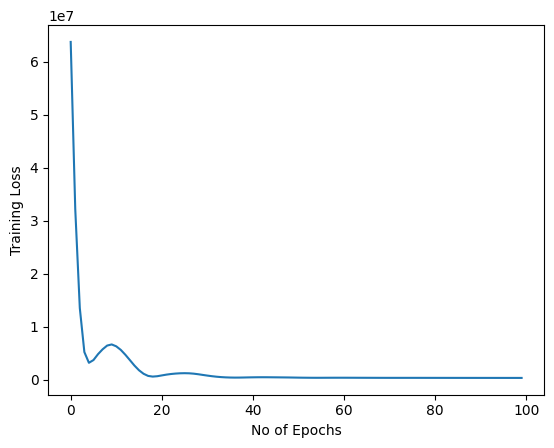

In [154]:
epochs = 100

losses = []

for _ in range(epochs):

    optimizer.zero_grad()
    y_pred = multi_channel_model(X)
    loss = criterion(y_pred, y)
    print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

#plot the training losses

plt.plot(losses)
plt.xlabel("No of Epochs")
plt.ylabel("Training Loss")


In [155]:
#Model Evaluation
def evaluate_forecasts(actual, predicted):
  
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores


In [156]:

train.shape


torch.Size([159, 7, 7])

In [157]:

train[-2][:, :].shape


torch.Size([7, 7])

In [159]:
#evaluation 

#get the last train 
n_test = len(test)
n_input = 14

#extract the last 7 days training data from train
history = train[-2][:, :].cat(train[-1][:, :])
#rehsape hist into (B, T, C)
B = 1
T = 14
C = 7

predictions = []

for i in range(n_test):
    n_in = 0
    # reshape the data from (B, T, C) -> (B, C, T)
    history = torch.tensor(history[-T]).view(B, T, C)
    # # reshape into [1, n_input, 1]
    with torch.no_grad():
        yhat = multi_channel_model.forward(history)
        # store the predictions
        predictions.append(yhat[0].tolist())
    history = history.extend(test[i][n_in:n_in+n_input, :])
    n_in += n_input
    
predictions = array(predictions)
score, scores = evaluate_forecasts(array(test[:, :, 0].tolist()), predictions)

AttributeError: 'Tensor' object has no attribute 'cat'

cnn: [1440.305] 1599.8, 1415.9, 1422.3, 1159.9, 1267.0, 1463.1, 1686.0


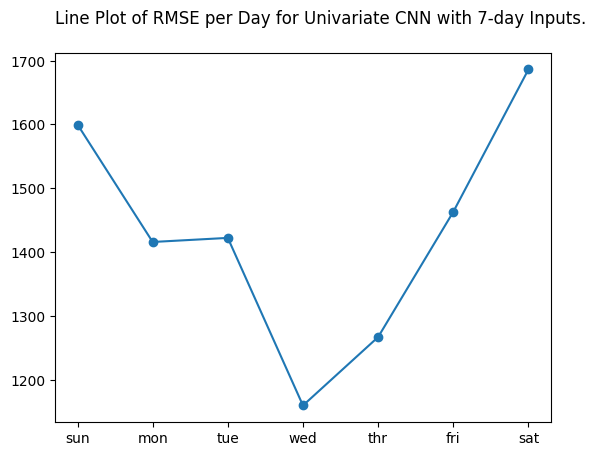

In [160]:
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn') 
plt.title("Line Plot of RMSE per Day for Univariate CNN with 7-day Inputs. \n", loc='left')
plt.show()

Multi-headed CNN Model
We can further extend the CNN model to have a separate sub-CNN model or head for each input variable, which we can refer to as a multi-headed CNN model.

This requires a modification to the preparation of the model, and in turn, modification to the preparation of the training and test datasets.

Starting with the model, we must define a separate CNN model for each of the eight input variables. The configuration of the model, including the number of layers and their hyperparameters, were also modified to better suit the new approach.

We can loop over each variable and create a submodel that takes a one-dimensional sequence of 14 days of data and outputs a flat vector containing a summary of the learned features from the sequence. Each of these vectors can be merged via concatenation to make one very long vector that is then interpreted by some fully connected layers before a prediction is made.

As we build up the submodels, we keep track of the input layers and flatten layers in lists. This is so that we can specify the inputs in the definition of the model object and use the list of flatten layers in the merge layer.

In [161]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [162]:

def split_dataset(data):
  # split into standard weeks
  train, test = data[1:-328], data[-328:-6]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/7))
  test = array(split(test, len(test)/7))
  return train, test

In [163]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [164]:
def plot_history(history):
    # plot loss
    plt.subplot(2, 1, 1) 
    plt.plot(history.history['loss'], label='train') 
    plt.plot(history.history['val_loss'], label='test') 
    plt.title('loss', y=0, loc='center') 
    plt.legend()
    # plot rmse
    plt.subplot(2, 1, 2) 
    plt.plot(history.history['rmse'], label='train') 
    plt.plot(history.history['val_rmse'], label='test') 
    plt.title('rmse', y=0, loc='center') 
    plt.legend()
    plt.show()

In [165]:
train, test = split_dataset(dataset.values)

print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (159, 7, 7), Test shape: (46, 7, 7)


In [167]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
     X.append(data[in_start:in_end, :])
     y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)

In [168]:
train_x, train_y = to_supervised(train, 14)

print(f"X : {train_x.shape}, Y : {train_y.shape}")


X : (1092, 14, 7), Y : (1092, 7)


In [170]:
import torch
import torch.nn as nn
import torch.optim as optim


# Assuming your data (train_x, train_y) is already loaded and preprocessed

class MultiHeadedCNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(MultiHeadedCNN, self).__init__()
        self.heads = nn.ModuleList([nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        ) for _ in range(n_features)])

        self.dense1 = nn.Linear(32 * n_features, 200)
        self.dense2 = nn.Linear(200, 100)
        self.out = nn.Linear(100, n_outputs)

    def forward(self, x):
        outputs = [head(x[:, i, :].unsqueeze(1)) for i, head in enumerate(self.heads)]
        merged = torch.cat(outputs, dim=1)
        # print(merged.shape)
        out = torch.relu(self.dense1(merged))
        out = torch.relu(self.dense2(out))
        out = self.out(out)
        return out

# Model initialization
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
model = MultiHeadedCNN(n_timesteps, n_features, n_outputs)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [171]:

# evaluate model and get scores
n_input = 14

In [172]:

# Converting data to PyTorch tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

In [173]:
train_x_tensor.shape


torch.Size([1092, 14, 7])

In [175]:
# Training loop
epochs = 20
train_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 364733.8750
Epoch [6/20], Loss: 364576.4375
Epoch [11/20], Loss: 370169.9375
Epoch [16/20], Loss: 361747.1250


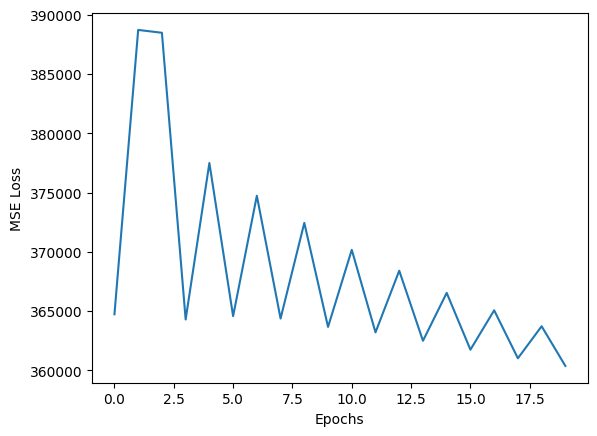

In [176]:
#plot the training loss
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

In [177]:

X.shape

torch.Size([1092, 14, 7])

In [178]:
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # print(input_x.shape)
  # reshape into n input arrays
  input_x = torch.tensor(input_x, dtype=torch.float32).view(1, n_input, 7)
  # print(input_x.shape)
  # forecast the next week
  yhat = model.forward(input_x)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

In [179]:

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
            score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

In [180]:
# Model Evaluation

# evaluate a single model
def evaluate_model(model, train, test, n_input):
 
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence.tolist())
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  # print(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores

cnn: [578.408] 600.1, 537.6, 504.3, 603.0, 608.3, 486.7, 684.1


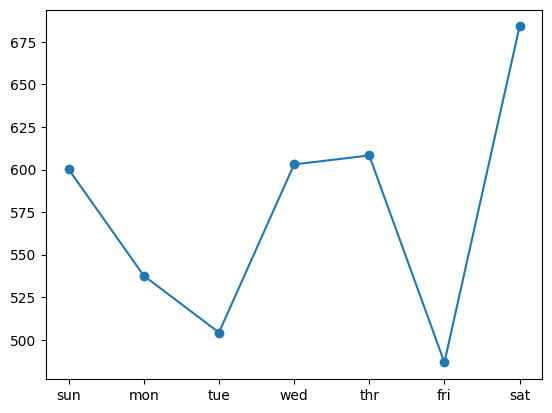

In [181]:

# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(model, train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn') 
plt.show()